In [9]:
!pip install xarray[viz] gcsfs zarr  intake-esm s3fs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104 kB 10.8 MB/s 
     |████████████████████████████████| 8.6 MB 44.0 MB/s 
     |████████████████████████████████| 138 kB 44.8 MB/s 
  Created wheel for aiobotocore: filename=aiobotocore-2.3.2-py3-none-any.whl size=111119 sha256=fb9329e3f2a7cb3ac64aa99d96c10c2db4e4301cb170c792ebad67dd4b07ef57
  Stored in directory: /root/.cache/pip/wheels/fb/48/61/f6b53f097fd8c9c14427058ee2c849ce3471ec1d7fa6039457
Successfully built aiobotocore
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatib

In [1]:
import intake
import numpy as np
import pandas as pd
import xarray as xr


In [2]:

catalog = intake.open_esm_datastore('https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json')
catalog
#catalog_subset = catalog.search(variable='TREFHT', frequency='daily')

,unique
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20
start_time,4


Print what we have

In [9]:
import pprint
uniques = catalog.unique(
    columns=["component", "frequency", "experiment", "variable"]
)
pprint.pprint(uniques, compact=True, indent=4)

{   'component': {'count': 4, 'values': ['atm', 'lnd', 'ocn', 'ice']},
    'experiment': {'count': 2, 'values': ['ssp370', 'historical']},
    'frequency': {'count': 3, 'values': ['daily', 'static', 'monthly']},
    'variable': {   'count': 53,
                    'values': [   'U', 'Z3', 'SOILWATER_10CM', 'SOILLIQ',
                                  'TEMP', 'QRUNOFF', 'hi', 'VNT', 'FLNS',
                                  'SALT', 'PRECL', 'V', 'ICEFRAC', 'DIC', 'UET',
                                  'FLUT', 'TREFHTMX', 'T', 'aice_d', 'UES',
                                  'PSL', 'TS', 'aice', 'WTS', 'hi_d', 'WTT',
                                  'TREFHTMN', 'O2', 'TREFMXAV', 'PRECSL', 'PS',
                                  'PRECC', 'FSNO', 'VNS', 'SNOW', 'RAIN',
                                  'TREFHT', 'PRECSC', 'NPP', 'WVEL', 'FSNSC',
                                  'Q', 'FSNS', 'TMQ', 'VVEL', 'PD', 'SHFLX',
                                  'DOC', 'H2OSNO', 'UVEL', 'LHFL

In [13]:
catalog_subset = catalog.search(variable='TREFHT', frequency='monthly')
dsets = catalog_subset.to_dataset_dict(storage_options={'anon':True})
dsets.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


dict_keys(['atm.historical.monthly.cmip6', 'atm.ssp370.monthly.cmip6', 'atm.ssp370.monthly.smbb', 'atm.historical.monthly.smbb'])

In [14]:
# Extract the Reference Height Temperature data variable
t_hist = dsets['atm.historical.monthly.cmip6']["TREFHT"]
t_ssp = dsets['atm.ssp370.monthly.cmip6']["TREFHT"]
t_ssp

,Array,Chunk
Bytes,11.41 GB,132.71 MB
Shape,"(50, 1032, 192, 288)","(1, 600, 192, 288)"
Count,101 Tasks,100 Chunks
Type,float32,numpy.ndarray


In [15]:
def calcMean(data):

    #unfortunatly not all models use lat/lon naming... fixing this
    if ('longitude' in data.dims) and ('latitude' in data.dims):
        data = data.rename({'longitude':'lon', 'latitude': 'lat'})

    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(("lon", "lat"),skipna=True)

In [17]:
t_ref = t_hist.sel(time=slice("1961", "1990"))
t_ref

,Array,Chunk
Bytes,3.98 GB,79.63 MB
Shape,"(50, 360, 192, 288)","(1, 360, 192, 288)"
Count,251 Tasks,50 Chunks
Type,float32,numpy.ndarray


Calc means

In [47]:
t_hist_mean = calcMean(t_hist).resample(time="AS").mean("time")
t_ssp_mean = calcMean(t_ssp).resample(time="AS").mean("time")
t_ref_mean = calcMean(t_ref).resample(time="AS").mean("time").mean()
t_hist_mean

,Array,Chunk
Bytes,66.00 kB,8 B
Shape,"(50, 165)","(1, 1)"
Count,43852 Tasks,8250 Chunks
Type,float64,numpy.ndarray


In [48]:
t_ref_mean

<xarray.DataArray 'TREFHT' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [95]:
obsDataURL = "https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/cru/hadcrut4/air.mon.anom.median.nc"
ds = xr.open_dataset(obsDataURL).load()
ds

<xarray.Dataset>
Dimensions:    (lat: 36, lon: 72, time: 2063, nbnds: 2)
Coordinates:
  * lat        (lat) float32 87.5 82.5 77.5 72.5 ... -72.5 -77.5 -82.5 -87.5
  * lon        (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2021-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 1850-01-01 1850-01-31 ... 2021-11-30
    air        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    platform:                        Surface
    title:                           HADCRUT4 Combined Air Temperature/SST An...
    history:                         Originally created at NOAA/ESRL PSD by C...
    Conventions:                     CF-1.0
    Comment:                         This dataset supersedes V3
    Source:                          Obtained from http://hadobs.metoffice.co...
    version:                         4.2.0
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   HadCRUT4
    DODS_EXTRA.Unlimited_Dimension:  time

In [96]:
ds = ds.drop_vars(['time_bnds'])
obs_mean = calcMean(ds).groupby('time.year').mean()

Calc Anomalies, good point to have coffee

In [50]:
hist_anom = (t_hist_mean - t_ref_mean).load()
ssp_anom = (t_ssp_mean - t_ref_mean).load()
hist_anom

<xarray.DataArray 'TREFHT' (member_id: 50, time: 165)>
array([[-0.11588679, -0.08422771, -0.26009288, ...,  1.10350725,
         1.14886398,  0.92319163],
       [-0.15445989, -0.12204201,  0.00849103, ...,  0.89097677,
         0.92085699,  0.84623633],
       [-0.08482308, -0.20354365, -0.09298379, ...,  1.11447604,
         1.03631605,  1.06679723],
       ...,
       [-0.09120349, -0.03316283, -0.05811529, ...,  0.85411481,
         1.00333763,  0.67497832],
       [-0.34468938, -0.24076115, -0.18779226, ...,  0.93674496,
         0.91726789,  1.23295407],
       [-0.30952935, -0.23723043, -0.20768448, ...,  0.74186191,
         0.86279302,  0.6749239 ]])
Coordinates:
  * time       (time) object 1850-01-01 00:00:00 ... 2014-01-01 00:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

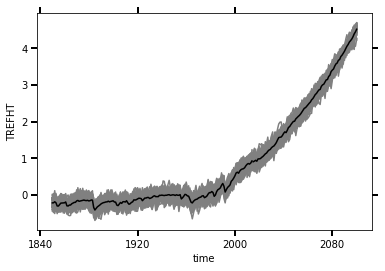

In [108]:
from matplotlib import pyplot as plt


ax = plt.axes()

ax.tick_params(
    right=True, top=True, direction="out", length=6, width=2, grid_alpha=0.5
)
hist_anom.plot.line(x="time",ax=ax, add_legend=False, color="grey")
ssp_anom.plot.line(x="time",ax=ax, add_legend=False, color="grey")
ssp_anom.mean("member_id").plot.line(x="time",ax=ax, add_legend=False, color="black")
hist_anom.mean("member_id").plot.line(x="time",ax=ax, add_legend=False, color="black")

#ax.set_xticks([1850, 1920, 1950, 2000, 2050, 2100])
#plt.ylim(-1, 5)
#plt.xlim(1850, 2100)
#plt.ylabel("Global Surface\nTemperature Anomaly (K)")
plt.show()

In [102]:
obs_mean.air

<xarray.DataArray 'air' (year: 172)>
array([-0.37116113, -0.20746703, -0.22178607, -0.2647787 , -0.24893646,
       -0.27515206, -0.36330488, -0.47177687, -0.470716  , -0.2890001 ,
       -0.35018274, -0.4244322 , -0.50774306, -0.29601637, -0.5026872 ,
       -0.291437  , -0.26061228, -0.32270804, -0.2612795 , -0.27091235,
       -0.2862917 , -0.32134625, -0.23790675, -0.30596963, -0.3811629 ,
       -0.39685833, -0.38243747, -0.07820304,  0.0434724 , -0.23271029,
       -0.2314905 , -0.20176022, -0.2157936 , -0.29735503, -0.40985954,
       -0.38919923, -0.3683697 , -0.4186075 , -0.3062953 , -0.17164725,
       -0.4166664 , -0.32650927, -0.4610339 , -0.48548314, -0.4055632 ,
       -0.39123276, -0.17938028, -0.201136  , -0.39858544, -0.28197762,
       -0.18911009, -0.24200761, -0.39915124, -0.47399473, -0.5179933 ,
       -0.37404656, -0.2735565 , -0.46684766, -0.5041326 , -0.51512784,
       -0.4841369 , -0.5320158 , -0.4436097 , -0.42715088, -0.2465627 ,
       -0.14082833, -0.38546288, -0.4793278 , -0.3435266 , -0.30551067,
       -0.25928143, -0.17280446, -0.29402992, -0.2723479 , -0.2844114 ,
       -0.20126116, -0.09483241, -0.19885224, -0.19873767, -0.34755206,
       -0.1142027 , -0.06444184, -0.12486266, -0.26741427, -0.11563701,
       -0.1666524 , -0.13323785, -0.01081604,  0.00939768, -0.02041332,
        0.01229037,  0.02572041, -0.00926817,  0.02897702,  0.15842195,
        0.02535979, -0.04575153, -0.02904064, -0.01910492, -0.06832371,
       -0.17645605, -0.03266565,  0.03178365,  0.11753425, -0.11453244,
       -0.16788839, -0.26546022, -0.00424019,  0.05705215,  0.02488249,
       -0.03776174,  0.0416766 ,  0.02459912,  0.06254535, -0.21417283,
       -0.14107485, -0.05763189, -0.05841933, -0.1072939 ,  0.02239829,
       -0.02955692, -0.18668927, -0.081714  ,  0.05755359, -0.21924794,
       -0.14684038, -0.24931121,  0.04657412, -0.06064526,  0.05445195,
        0.09133289,  0.1458652 ,  0.0072619 ,  0.19195412, -0.01926049,
       -0.03574914,  0.04288438,  0.1899342 ,  0.20210755,  0.12200134,
        0.3070794 ,  0.26075873,  0.10010803,  0.14575663,  0.21660666,
        0.33645168,  0.1805535 ,  0.39546576,  0.5471955 ,  0.3158643 ,
        0.30697292,  0.45365295,  0.5054221 ,  0.51926005,  0.45878065,
        0.56034005,  0.5173405 ,  0.5058686 ,  0.40447378,  0.5110313 ,
        0.5706486 ,  0.43498564,  0.48415515,  0.5321876 ,  0.5990458 ,
        0.78256726,  0.8142471 ,  0.6972205 ,  0.6103153 ,  0.752206  ,
        0.79094154,  0.66832596], dtype=float32)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2017 2018 2019 2020 2021